# Relevant Imports

In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['PYTHONHASHSEED'] = str(50)

# Load and split data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')

# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '\n\n')

seed = 11

# Split Data - 60 20 20 split
X_split, X_val, y_split, y_val = train_test_split(X, y, test_size = 0.20, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
fed.SetTestData({'Data': X_test, 'Labels': y_test})

total_x = 0
total_y = 0
for a, b in zip(data['Client Data'], data['Client Labels']):
    total_x += len(a)
    total_y += len(b)
print(f'Total Client Training Samples: {total_x}')
print(f'Total Client Training Labels: {total_y}')
print(f'Total Validation Samples: {len(X_val)}')
print(f'Total Validation Labels: {len(y_val)}')
print(f'Total Test Samples: {len(X_test)}')
print(f'Total Test Labels: {len(y_test)}')

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

Total Client Training Samples: 17748
Total Client Training Labels: 17748
Total Validation Samples: 5917
Total Validation Labels: 5917
Total Test Samples: 5916
Total Test Labels: 5916


### Load FedAvg Baseline Data

In [3]:
fedavg_test_mse = np.load('history/important baselines/fedavg_test_mse_sep.npy')
fedavg_log = np.load('history/important baselines/fedavg_log_sep.npy')

# Ablation Study: Mt = 5, $\alpha = 0.01$ and $\lambda = 0.01$

In [4]:
history = dict()
base_mse = dict()
base_log = dict()
Mt = (np.ones(50) * 5).astype('int32')

context_elements = [
    [0, 1, 2, 3, 4],
    [0],
    [1],
    [2],
    [3],
    [4],
    [1, 2, 3, 4],
    [0, 2, 3, 4],
    [0, 1, 3, 4],
    [0, 1, 2, 4],
    [0, 1, 2, 3]
]

In [5]:
count = 1
for context in context_elements:
    print(f'Training Model {count}')
    fed.SetContextElements(context)
    w, b = fed.ConFeddi(.01, .01, rounds = 50, Mt = Mt)
    mse = fed.test_loss()
    log = fed.GetLog()
    history[tuple(context)] = (mse, log)
    count += 1

    if context == [0, 1, 2, 3, 4]:
        base_mse[tuple(context)] = mse
        base_log[tuple(context)] = log
    fed.clear_history()
    print()

Training Model 1
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 2
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 3
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 4
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 5
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 6
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 7
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 8
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 9
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 10
Round 5
Round 10
Ro

# Ablation Stats

Final FedAvg: 0.3371109366416931
context = (0,), True, Final Test Error: 0.23014651238918304
context = (1,), False, Final Test Error: 0.6350897550582886
context = (2,), False, Final Test Error: 0.42458629608154297
context = (3,), False, Final Test Error: 0.4002545177936554
context = (4,), False, Final Test Error: 0.45447561144828796
context = (1, 2, 3, 4), False, Final Test Error: 0.3578481376171112
context = (0, 2, 3, 4), True, Final Test Error: 0.31433892250061035
context = (0, 1, 3, 4), False, Final Test Error: 0.3664624094963074
context = (0, 1, 2, 4), False, Final Test Error: 0.7263336181640625
context = (0, 1, 2, 3), True, Final Test Error: 0.33629247546195984


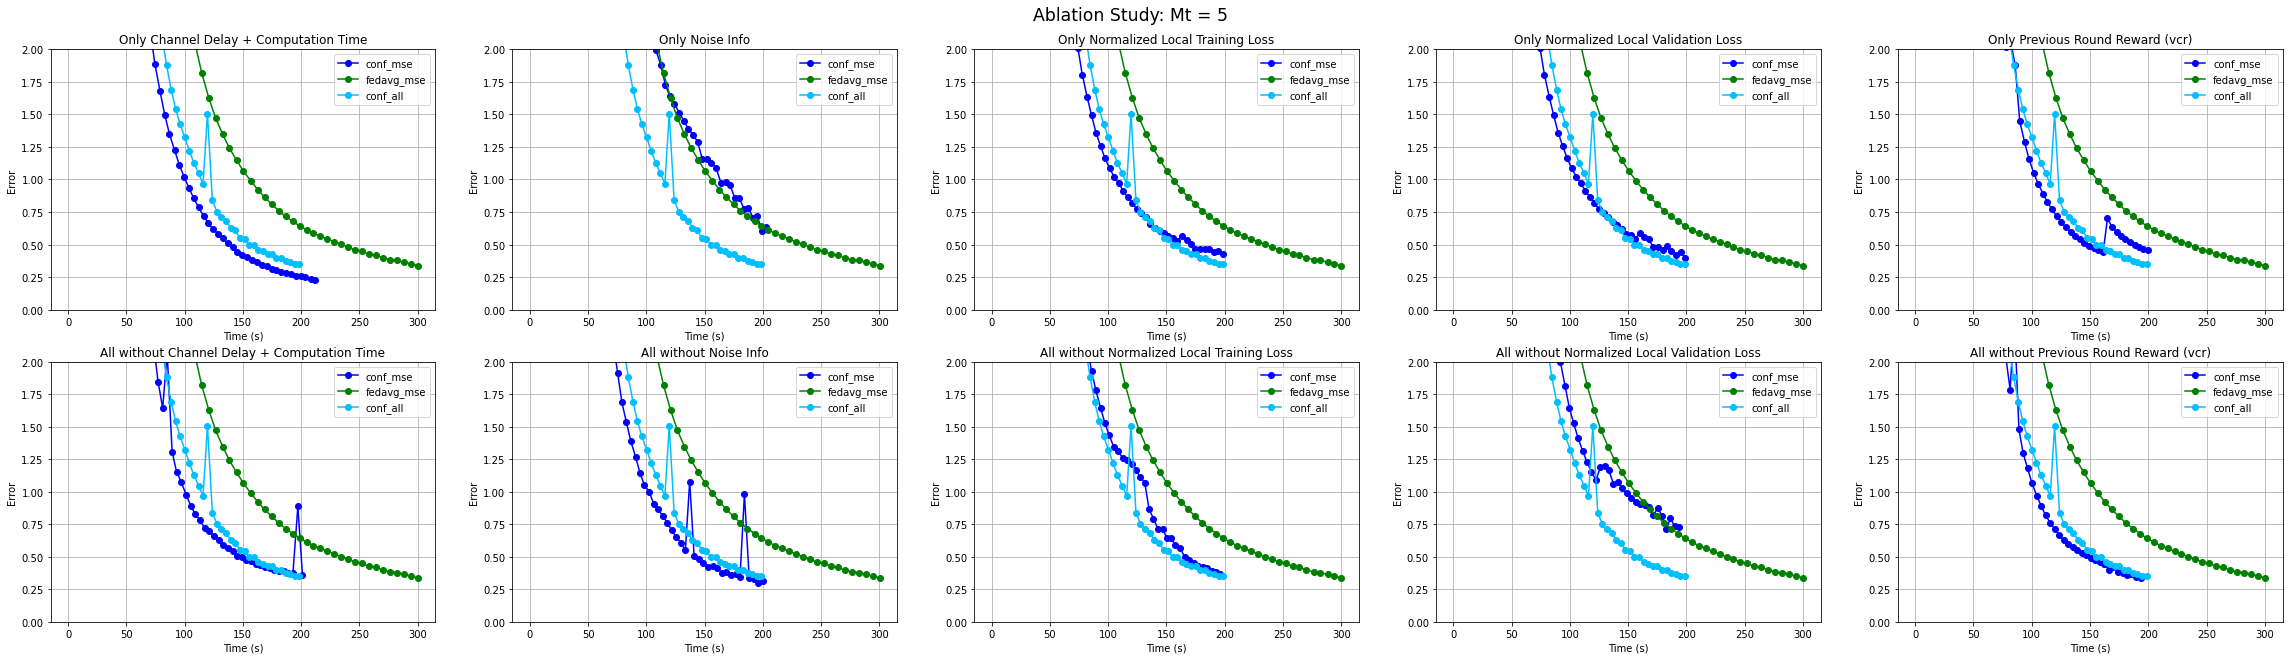

In [6]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Ablation Study: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)
print(f'Final FedAvg: {fedavg_test_mse[-1]}')

titles = {
    (0,): 'Only Channel Delay + Computation Time',
    (1,): 'Only Noise Info',
    (2,): 'Only Normalized Local Training Loss',
    (3,): 'Only Normalized Local Validation Loss',
    (4,): 'Only Previous Round Reward (vcr)',
    (1, 2, 3, 4): 'All without Channel Delay + Computation Time',
    (0, 2, 3, 4): 'All without Noise Info',
    (0, 1, 3, 4): 'All without Normalized Local Training Loss',
    (0, 1, 2, 4): 'All without Normalized Local Validation Loss',
    (0, 1, 2, 3): 'All without Previous Round Reward (vcr)'
}

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_test_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
    

    plt.plot(base_log[tuple([0, 1, 2, 3, 4])], base_mse[tuple([0, 1, 2, 3, 4])], color = 'deepskyblue', label = 'conf_all', marker = 'o')

    # When using final a and l, change title to Remove <specific context>
    plt.title(titles[context])
    plt.ylim(0, 2)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.grid()
    plt.legend()

    print(f'context = {context}, {fedavg_test_mse[-1] > err[-1]}, Final Test Error: {err[-1]}')

    plot += 1

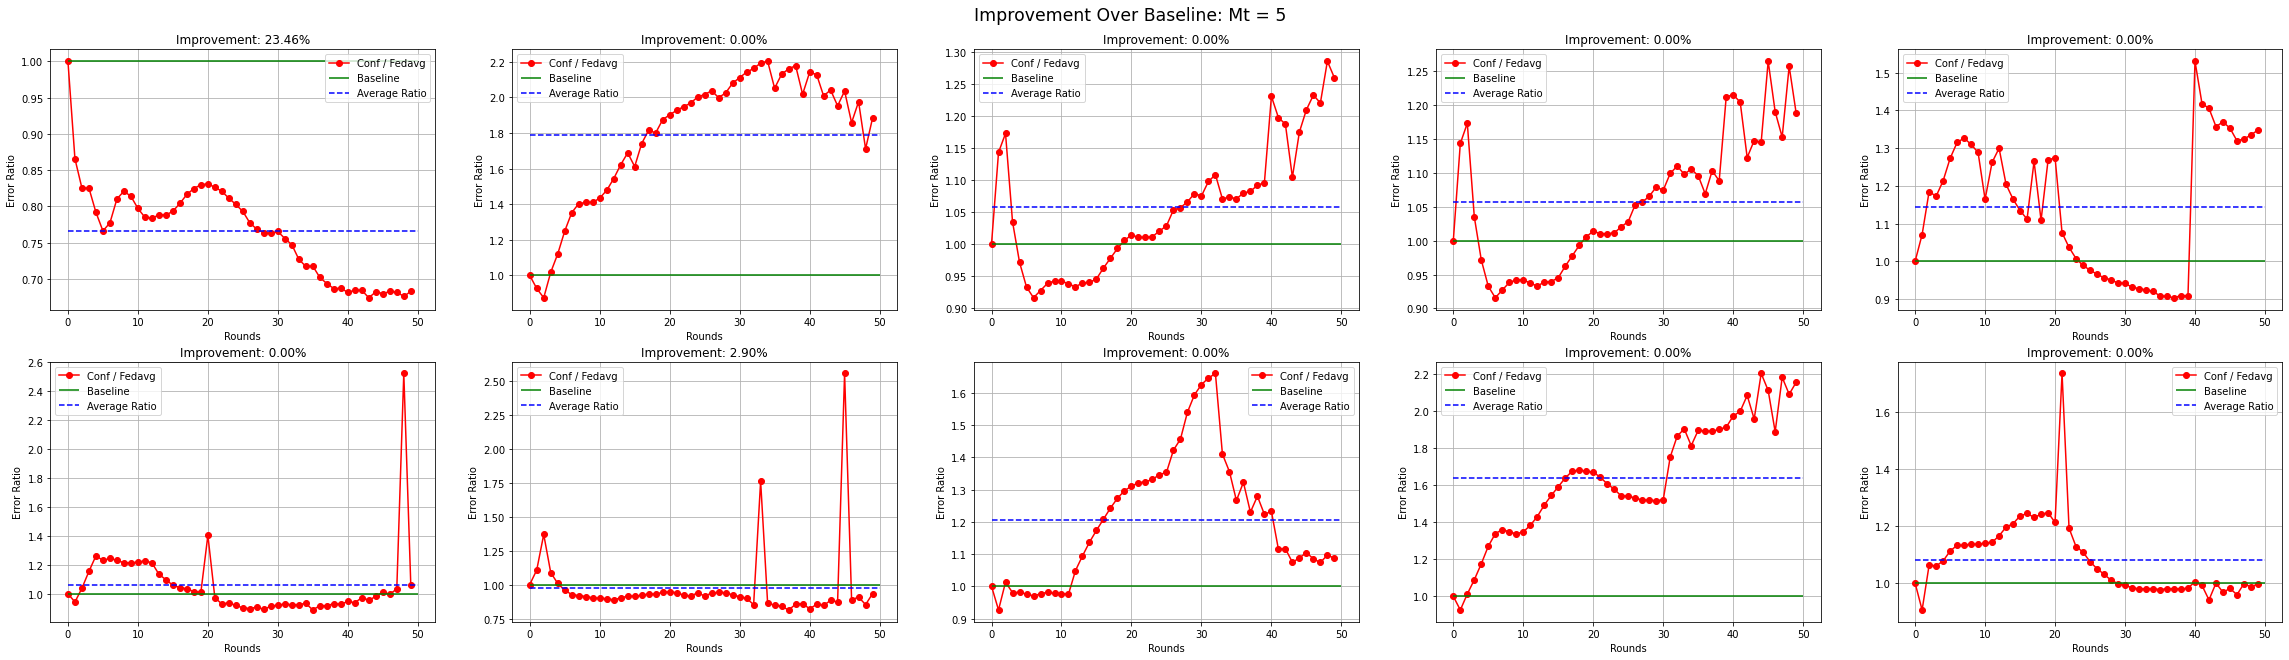

In [7]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Improvement Over Baseline: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)

    ratios = np.array(err[1:]) / np.array(fedavg_test_mse[1:]) 
    scale = np.array(time[1:]) / np.array(fedavg_log[1:])
    timescaled = scale * ratios # multiplied by scale before
    plt.plot(ratios, color = 'red', label = 'Conf / Fedavg', marker = 'o')

    score = 1 - timescaled.mean()
    improvement = 1 - ratios.mean()
    if score < 0: score = 0
    if improvement < 0: improvement = 0
    plt.title(f'Improvement: {improvement * 100:.2f}%')
    plt.ylabel('Error Ratio')
    plt.xlabel('Rounds')
    plt.hlines(1, 0, 50, color = 'green', label = 'Baseline')
    plt.hlines(ratios.mean(), 0, 50, color = 'blue', label = 'Average Ratio', linestyle = 'dashed')
    plt.grid()
    plt.legend()


    plot += 1

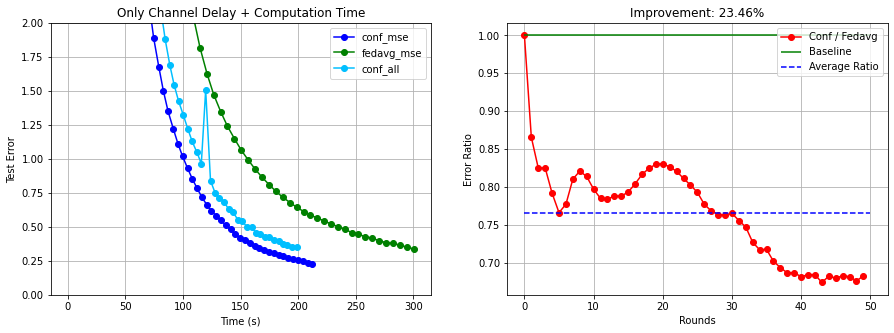

In [8]:
r, c, = 1, 2
fig = plt.figure(figsize = (15, 5))


run = list(history.items())[1]
context = run[0]
err, time = run[1]
fig.add_subplot(r, c, 1)

plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
plt.plot(fedavg_log, fedavg_test_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
plt.plot(base_log[tuple([0, 1, 2, 3, 4])], base_mse[tuple([0, 1, 2, 3, 4])], color = 'deepskyblue', label = 'conf_all', marker = 'o')
plt.title(titles[context])
plt.ylabel('Test Error')
plt.xlabel('Time (s)')
plt.ylim(0, 2)
plt.grid()
plt.legend()

fig.add_subplot(r, c, 2)
ratios = np.array(err[1:]) / np.array(fedavg_test_mse[1:])
plt.plot(ratios, color = 'red', label = 'Conf / Fedavg', marker = 'o')
plt.title(f'Improvement: {(1 - ratios.mean()) * 100:.2f}%')
plt.ylabel('Error Ratio')
plt.xlabel('Rounds')
plt.hlines(1, 0, 50, color = 'green', label = 'Baseline')
plt.hlines(ratios.mean(), 0, 50, color = 'blue', label = 'Average Ratio', linestyle = 'dashed')
plt.grid()
plt.legend()

Final FedAvg: 0.3371109366416931
context = (0,), True, Final Test Error: 0.23014651238918304
context = (0, 2, 3, 4), True, Final Test Error: 0.31433892250061035
context = (0, 1, 2, 3), True, Final Test Error: 0.33629247546195984


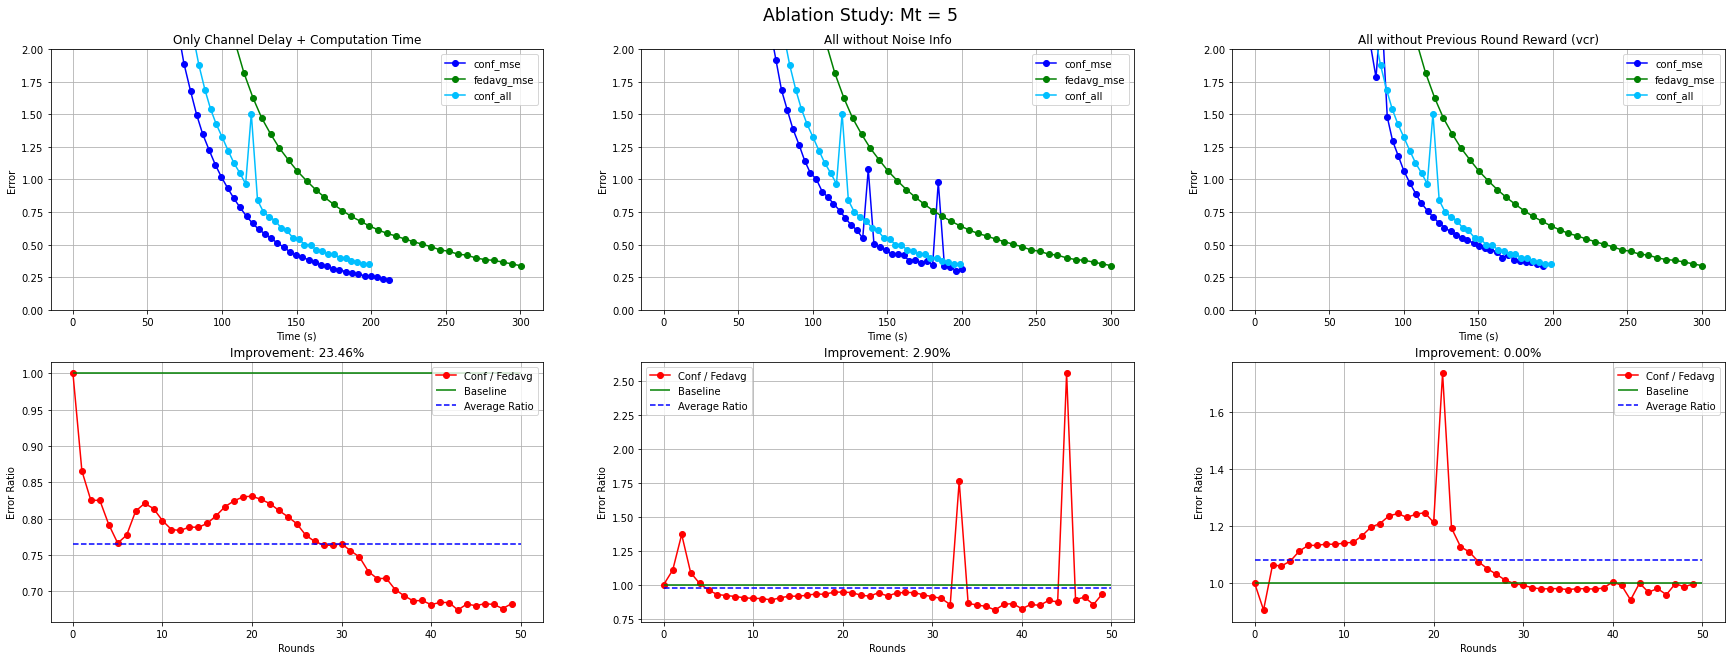

In [14]:
r, c, = 2, 3
fig = plt.figure(figsize = (30, 10))
plt.suptitle('Ablation Study: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)
print(f'Final FedAvg: {fedavg_test_mse[-1]}')

titles = {
    (0,): 'Only Channel Delay + Computation Time',
    (1,): 'Only Noise Info',
    (2,): 'Only Normalized Local Training Loss',
    (3,): 'Only Normalized Local Validation Loss',
    (4,): 'Only Previous Round Reward (vcr)',
    (1, 2, 3, 4): 'All without Channel Delay + Computation Time',
    (0, 2, 3, 4): 'All without Noise Info',
    (0, 1, 3, 4): 'All without Normalized Local Training Loss',
    (0, 1, 2, 4): 'All without Normalized Local Validation Loss',
    (0, 1, 2, 3): 'All without Previous Round Reward (vcr)'
}

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    if (context == (0,)) or (context == (0, 2, 3, 4)) or (context == (0, 1, 2, 3)):
        err, time = run[1]
        fig.add_subplot(r, c, plot)
        plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
        plt.plot(fedavg_log, fedavg_test_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
        

        plt.plot(base_log[tuple([0, 1, 2, 3, 4])], base_mse[tuple([0, 1, 2, 3, 4])], color = 'deepskyblue', label = 'conf_all', marker = 'o')

        # When using final a and l, change title to Remove <specific context>
        plt.title(titles[context])
        plt.ylim(0, 2)
        plt.ylabel('Error')
        plt.xlabel('Time (s)')
        plt.grid()
        plt.legend()

        fig.add_subplot(r, c, plot + 3)

        ratios = np.array(err[1:]) / np.array(fedavg_test_mse[1:]) 
        plt.plot(ratios, color = 'red', label = 'Conf / Fedavg', marker = 'o')
        improvement = 1 - ratios.mean()
        if improvement < 0: improvement = 0
        plt.title(f'Improvement: {improvement * 100:.2f}%')
        plt.ylabel('Error Ratio')
        plt.xlabel('Rounds')
        plt.hlines(1, 0, 50, color = 'green', label = 'Baseline')
        plt.hlines(ratios.mean(), 0, 50, color = 'blue', label = 'Average Ratio', linestyle = 'dashed')
        plt.grid()
        plt.legend()

        print(f'context = {context}, {fedavg_test_mse[-1] > err[-1]}, Final Test Error: {err[-1]}')
        plot += 1
